<a href="https://colab.research.google.com/github/saipramodkudapa/covid-mobility-trend-analysis/blob/main/mobility_trend_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Uploading Raw datasets
from google.colab import drive
drive.mount('/content/drive')
# Need to upload below files here
# raw covid dataset filename = covid_world_data.csv
# raw X dataset filename = Global_Mobility_Report.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## all imports placed here
import pandas as pd
import numpy as np
%matplotlib inline
from builtins import print
import math
import random
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.stats import geom, poisson, binom

In [ ]:
cd /content/drive/My\ Drive/CSE544

/content/drive/.shortcut-targets-by-id/15rcFuz2CMtE54gJvLS1O-QiRzQM3-9eo/CSE544


In [ ]:
# Cleaning dataset and outlier removal

# function to clean dataset as our project requires Our dataset has all countries around the world, in cleaning we have only
# kept Italy, Spain, France, Germany, United_kingdom, Turkey data
def func1(df):
    countries = ['Italy', 'Spain', 'France', 'Germany', 'United_Kingdom', 'Turkey'] #subset if countries we are doing inferences on
    df = df[df['countriesAndTerritories'].isin(countries)] #Seeing if data is in our decided countries
    df = df.drop(columns=['month', 'year', 'geoId', 'countryterritoryCode', 'popData2018', 'continentExp']) #dropping unneccesary data columns
    df = df.rename(columns={'cases': 'confirmed_cases','deaths': 'death_cases', 'countriesAndTerritories': 'country', 'dateRep': 'date'}) #renaming columns so that they are easy to figure out
    df = df[['date', 'day','country', 'confirmed_cases', 'death_cases']] #reodering the columns so that easy to read
    dataframe=pd.DataFrame(df)
    dataframe['date'] = pd.to_datetime(dataframe['date'], format='%d/%m/%Y').dt.strftime('%m-%d-%Y') #changed the date format so that it be consistent throughout the project
    dataframe = dataframe[(dataframe.date.between("04-01-2020", "04-30-2020"))] #filtering data to the 1 month span as we are including 6 countries in all the inferences
    return dataframe


raw_df = pd.read_csv('covid_world_data.csv') #reading main dataset that is covid world data
datafr1 = func1(raw_df) #data frame returned by func1

final_df = pd.DataFrame() #creating the final dataframe
list_country = ['Italy', 'Spain', 'France', 'Germany', 'United_Kingdom', 'Turkey'] #list of countries required
for country in list_country:
    rows = datafr1.loc[(datafr1['country'] == country)] #selecting rows that are in our list of countries
    nr = pd.DataFrame(rows.sort_values(by='date')) #sorting data by date so that most recent appears in the last
    final_df = pd.concat([final_df,nr], axis=0) #concatenating all the countries dataframe to one

final_df.to_csv('cleaned_covid_data.csv', index=False) #making a new csv tha has required data in required format

### Cleaning X dataset
country_list = ['Italy', 'Spain', 'France', 'Germany', 'United Kingdom', 'Turkey'] #subset of contries in intersection with main covid dataset

data = pd.read_csv('Global_Mobility_Report.csv', low_memory=False) #reading Global Mobility report dataset by google that gives the percentage change in mobility as compared to pre-covid days
new_df=pd.DataFrame() #creating a dataframe
for index, row in data.iterrows(): #iterating over all rows of dataset
    if row['country_region'] in country_list and pd.isnull(row['sub_region_1'] ): #selecting rows with our country list and since it has states wise data for each country as well we are selecting only country specific as a whole
        row_df = pd.DataFrame([row]) #creating a dataframe of a row
        new_df = pd.concat([row_df, new_df]) #concatenating all row df in our new df

new_df['date'] = pd.to_datetime(new_df['date'], format='%Y/%m/%d').dt.strftime('%m-%d-%Y') #changing the date format as it is in covid dataset
new_df = new_df[(new_df.date.between("04-01-2020", "04-30-2020"))] #selecting the rows that lie in the one month span
new_df.drop(['sub_region_1','sub_region_2', 'country_region_code'],axis = 1,inplace=True) #dropping unnecessary columns
final_df = pd.DataFrame() #creating a final dataframe

for country in country_list: #iterating over country list again
    rows = new_df.loc[(new_df['country_region'] == country)] #selecting all rows with the same country
    nr = pd.DataFrame(rows.sort_values(by='date')) #sorting by date from the most recent in the last for each country
    final_df = pd.concat([final_df,nr], axis=0) #concatenating this sorted date data for each country in to the final data frame

final_df.to_csv("cleaned_X_dataset.csv",index=False) #creating a new csv from the dataframe which has data in required format.


#############################################
##Outlier Detections

covid_df = pd.read_csv('cleaned_covid_data.csv')
x_df = pd.read_csv('cleaned_X_dataset.csv')

alpha = 2.5
for country, group in covid_df.groupby('country'):
  q1 = group.quantile(0.25)
  q3 = group.quantile(0.75)
  iqr = q3-q1
  lower = q1 - alpha*iqr
  upper = q3 + alpha*iqr
  covid_outliers = group[((group < lower) |(group > upper)).any(axis=1)]
  print(covid_outliers)
  filtered_group = group[~((group < lower) |(group > upper)).any(axis=1)]

## outlier indices for covid
covid_outlier_indices = [63, 131]
##removing outliers for covid dataset
filtered_covid_df = covid_df.drop(covid_outlier_indices)

x_alpha = 5.0
for country, group in x_df.groupby('country_region'):
  q1 = group.quantile(0.25)
  q3 = group.quantile(0.75)
  iqr = q3-q1
  lower = q1 - x_alpha*iqr
  upper = q3 + x_alpha*iqr
  x_outliers = group[((group < lower) |(group > upper)).any(axis=1)]
  print(x_outliers)
  filtered_group = group[~((group < lower) |(group > upper)).any(axis=1)]

## outlier indices for X
x_outlier_indices = [99, 102, 131]
##removing outliers for X dataset
filtered_x_df = x_df.drop(x_outlier_indices)

          date  day country  confirmed_cases  death_cases
63  04-04-2020    4  France             5233         2004
Empty DataFrame
Columns: [date, day, country, confirmed_cases, death_cases]
Index: []
Empty DataFrame
Columns: [date, day, country, confirmed_cases, death_cases]
Index: []
Empty DataFrame
Columns: [date, day, country, confirmed_cases, death_cases]
Index: []
Empty DataFrame
Columns: [date, day, country, confirmed_cases, death_cases]
Index: []
           date  day         country  confirmed_cases  death_cases
131  04-12-2020   12  United_Kingdom             8719          839
Empty DataFrame
Columns: [country_region, date, retail_and_recreation_percent_change_from_baseline, grocery_and_pharmacy_percent_change_from_baseline, parks_percent_change_from_baseline, transit_stations_percent_change_from_baseline, workplaces_percent_change_from_baseline, residential_percent_change_from_baseline]
Index: []
    country_region  ... residential_percent_change_from_baseline
99         Ger

In [ ]:
## Basic Visualizations for Covid and X datasets...
## Creating Line plots

covid_plot_df = filtered_covid_df.drop(columns=['day'])
x_plot_df = filtered_x_df

## Covid basic viz
for country, group in covid_plot_df.groupby('country'):
  p = group.plot(figsize=(20,5), use_index=False)
  p.set_title(country, fontsize=30)
  p.set_xlabel('Dates')
  p.set_ylabel('Number of Cases/Deaths')

## X basic viz
for country, group in x_plot_df.groupby('country_region'):
  p = group.plot(figsize=(20,5), use_index=False)
  p.set_title(country, fontsize=30)

In [ ]:
## Required Inference 1
## Time series Analysis


#reading cleaned covid dataset
#file = pd.read_csv("cleaned_covid_data.csv")
file = filtered_covid_df
# set of countries on which required inference is done
country_list = ['Italy', 'Spain', 'France', 'Germany', 'United_Kingdom', 'Turkey']
df = pd.DataFrame(file)
# daily confirmed cases and death cases
case_type = ['confirmed_cases', 'death_cases']



# populating data in the required form and calculating betas using OLS regression
# this function predicts the t+1 data using the data series given
def ar5(data):
    n = len(data)  # n is total length of the data
    X1 = data[0:-5]  # data slice form (0 n-6) where n is the index number
    X2 = data[1:-4]  # data slice form (1 n-5)
    X3 = data[2:-3]  # data slice form (2 n-3)
    X4 = data[3:-2]  # data slice form (3 n-2)
    X5 = data[4:-1]  # data slice form (4 n-1)
    X0 = [1] * (n - 5)  # rows of 1 and no of data points is t-5 here t is time
    X = np.array([X0, X1, X2, X3, X4, X5]).T
    y = data[5:]  # no of data points is t-5
    betas = regression(X, y)  # multiple linear regression to calucalte betas
    return betas


# this function calclulates betas value for the timeseries data using multiple linear regression
def ar3(data):
    n = len(data)  # n is total length of the data
    X1 = data[0:-3]  # data slice form (0 n-4)
    X2 = data[1:-2]  # data slice form (1 n-3)
    X3 = data[2:-1]  # data slice form (2 n-2)
    X0 = [1] * (n - 3)  # rows of 1 and no of data points is t-3
    X = np.array([X0, X1, X2, X3]).T  # creating matrix/array of X0, X1, X2, X3
    y = data[3:]  # no of data points for regresssion is t-3
    betas = regression(X, y)  # multiple linear regression for calucalting betas
    return betas


# return beta value for the multiple linear regression
def regression(X, y):
    betas = []
    betas = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(
        y)  # matrix formula for multiple linear regression
    return betas


# predic t+1 using data from 1-t time
def predict_ar3(data):
    data = np.array(data)
    betas = ar3(data)  # get betas values from the function
    k = data[-3:]  # last three values of the data
    predicted = np.sum(betas[1:] * k) + betas[
        0]  # calculating t+1 value by multiplying betas with respective data points
    return predicted  # return predicted value


def predict_ar5(data):
    data = np.array(data)
    betas = ar5(data)
    k = data[-5:]
    predicted = np.sum(betas[1:] * k) + betas[0]
    return predicted


# this functions take the data of 28 days and predict the value of data of last 7 days using ar3
# i.e from day 22 to day 28
# the predicted and actual data is then used to calculate mse and mape
# for nth day prediction n-1th days actual data is used
def test_model_ar3(data28):
    predict_list = []
    for i in range(7):  # loop to caluclate value from day 22 to 28
        data = data28[:len(data28) - 7 + i]  # actual data for n days.
        predicted = predict_ar3(data)  # predict value using ar3
        predict_list.append(int(predicted))  # append the predicted value of nth day to list
    actual_y = data28[-7:]  # actual data of last 7 days
    mape, mse = errorforaccuracy(actual_y, predict_list)  # calulate mse and mape
    return int(mape), int(mse), predict_list  # return values


# this functions take the data of 28 days and predict the value of data of last 7 days using ar5
# i.e from day 22 to day 28
# the predicted and actual data is then used to calculate mse and mape
# for nth day prediction n-1th days actual data is used
def test_model_ar5(data28):
    predict_list = []
    for i in range(7):
        data = data28[:len(data28) - 7 + i]
        predicted = predict_ar5(data)
        predict_list.append(int(predicted))
    actual_y = data28[-7:]
    mape, mse = errorforaccuracy(actual_y, predict_list)
    return int(mape), int(mse), predict_list

#This function calculates MAPE and MSE error for all the time series model
def errorforaccuracy(actual_y, predicted_values):
    mape_error = 0 #initialized to zero
    mse = 0
    for i, j in zip(actual_y, predicted_values):
        if i != 0: #to handle zero division error when actual data point is zero
            mape_error = mape_error + (abs(i - j) / i * 100)
    mse = mse + ((i - j) ** 2)
    mape_error = mape_error / len(actual_y)
    mse = mse / len(actual_y)
    return mape_error, mse

# this functions take the data of 28 days and alpha value and predict the value of data of last 7 days using ar5
# i.e from day 22 to day 28
# the predicted and actual data is then used to calculate mse and mape
# for nth day prediction weighted (alpha) n-1th days actual data is used and weighted (1-alpha) n-1th days predicted data is used
def test_model_ewma(data28, alpha=0.5):
    predict_list = []
    for i in range(7):
        data = data28[:len(data28) - 7 + i]
        predicted = ewma(data, alpha)
        predict_list.append(int(predicted))
    actual_y = data28[-7:]
    mape, mse = errorforaccuracy(actual_y, predict_list)
    return int(mape), int(mse), predict_list

#this method returns t-th day
def ewma(data, alpha):
    n = len(data)
    predicted = [0] * len(data)  # predicted value of length of data
    predicted[0] = data[0]  # initializing the starting point with the actual value
    for j in range(1, len(data)):
        val = alpha * data[j - 1] + (1 - alpha) * predicted[j - 1]
        predicted[j] = val  # calucating the t th day value using t-1 th day actual and predicted value
    return alpha * data[n - 1] + (1 - alpha) * predicted[n - 1]  # returns the t+1 th day value


# loop to calulate the mse, mape and predcited value of the fatality and no of covid confirmed cases of each selected countries
# from 04-22-2020 to 04-28-2020
# using ar3 ar5 and ewma with alpha=0.5 and 0.8
def all_countries(country_list, case_type):
    for c in country_list:
        for case in case_type:
            rows = df[(df.date.between("04-01-2020", "04-28-2020")) & (df['country'] == c)][case]
            data = rows.tolist()
            mape2, mse2, predict_list2 = test_model_ewma(data, alpha=0.5)
            mape3, mse3, predict_list3 = test_model_ewma(data, alpha=0.8)
            mape, mse, predict_list = test_model_ar3(data)
            mape1, mse1, predict_list1 = test_model_ar5(data)
            print("----For ", case, "in country", c, "-----------------------------------")
            print("predicted values for 4th week    = ", predict_list)
            print("Using AR3 model : ", "mape error = ", mape, "%", ", mse error = ", mse)
            print()
            print("predicted values for 4th week    = ", predict_list1)
            print("Using AR5 model : ", "mape error = ", mape1, "%", ", mse error = ", mse1)
            print()
            print("predicted values for 4th week    = ", predict_list2)
            print("Using EWMA model with alpha  0.5 : ", "mape error = ", mape2, "%", ", mse error = ", mse2)
            print()
            print("predicted values for 4th week    = ", predict_list3)
            print("Using EWMA model with alpha  0.8 : ", "mape error = ", mape3, "%", ", mse error = ", mse3)
            print()
            print()



all_countries(country_list, case_type) #calling this method to calculate predicted values by all time series model

----For  confirmed_cases in country Italy -----------------------------------
predicted values for 4th week    =  [2550, 3092, 3606, 2741, 3224, 2617, 2581]
Using AR3 model :  mape error =  22 % , mse error =  101280

predicted values for 4th week    =  [2697, 3028, 3641, 2827, 2805, 2208, 2847]
Using AR5 model :  mape error =  20 % , mse error =  175380

predicted values for 4th week    =  [2756, 2742, 3056, 2851, 2936, 2646, 2485]
Using EWMA model with alpha  0.5 :  mape error =  17 % , mse error =  79502

predicted values for 4th week    =  [2432, 2669, 3229, 2762, 2969, 2479, 2355]
Using EWMA model with alpha  0.8 :  mape error =  18 % , mse error =  54208


----For  death_cases in country Italy -----------------------------------
predicted values for 4th week    =  [474, 495, 472, 499, 448, 445, 351]
Using AR3 model :  mape error =  18 % , mse error =  46

predicted values for 4th week    =  [529, 497, 480, 500, 498, 443, 379]
Using AR5 model :  mape error =  20 % , mse error =  3

In [ ]:
## required inference 2
## last week mean vs second last week mean using walds, z, t

final_df = filtered_covid_df
true_sd_df = final_df.groupby('country').agg(np.std, ddof=0)

last_week_df = final_df.loc[(final_df['day'] > 23) & (final_df['day'] <= 30)]
second_last_week_df = final_df.loc[(final_df['day'] > 16) & (final_df['day'] <= 23)]

second_last_week_mean_df = second_last_week_df.groupby('country').mean()
last_week_mean_df = last_week_df.groupby('country').mean()

sample_sd_deaths = []
sample_sd_cases = []
gb_country = last_week_df.groupby('country')
for country, group in gb_country:
  sample_sd_deaths.append(np.sqrt(np.sum(np.square(group['death_cases'] - np.mean(group['death_cases'])))/7))
  sample_sd_cases.append(np.sqrt(np.sum(np.square(group['confirmed_cases'] - np.mean(group['confirmed_cases'])))/7))

lw_grouped = last_week_df.groupby('country')
slw_grouped = second_last_week_df.groupby('country')
countries = ['France', 'Germany', 'Italy', 'Spain', 'Turkey', 'United_Kingdom']
ssd_diff_deaths = []
ssd_diff_cases = []

sv_lw_deaths = []
sv_lw_cases = []
sv_slw_deaths = []
sv_slw_cases = []
for country in countries:
  lw_deaths = np.array(lw_grouped.get_group(country)['death_cases'])
  slw_deaths = np.array(slw_grouped.get_group(country)['death_cases'])
  death_diffs_ssd = np.sqrt(np.var(lw_deaths - slw_deaths))
  ssd_diff_deaths.append(death_diffs_ssd)
  sv_lw_deaths.append(np.var(lw_deaths))
  sv_slw_deaths.append(np.var(slw_deaths))
  
  lw_cases = np.array(lw_grouped.get_group(country)['confirmed_cases'])
  slw_cases = np.array(slw_grouped.get_group(country)['confirmed_cases'])
  cases_diffs_ssd = np.sqrt(np.var(lw_cases - slw_cases))
  ssd_diff_cases.append(cases_diffs_ssd)
  sv_lw_cases.append(np.var(lw_cases))
  sv_slw_cases.append(np.var(slw_cases))

alpha = 0.05  
z_alpha_by2 = st.norm.ppf(1-alpha/2)
t_critical_value = 2.447

#Walds Test
w1_deaths_num = last_week_mean_df['death_cases'] - second_last_week_mean_df['death_cases']
w1_deaths_den = np.sqrt(last_week_mean_df['death_cases']/7)
last_week_mean_df['w1_deaths'] = w1_deaths_num/w1_deaths_den
last_week_mean_df['w1_d_res'] = np.abs(w1_deaths_num/w1_deaths_den) > z_alpha_by2
last_week_mean_df['w1_d_res'] = np.where(last_week_mean_df['w1_d_res'], 'Reject', 'Accept')

w1_cases_num = last_week_mean_df['confirmed_cases'] - second_last_week_mean_df['confirmed_cases']
w1_cases_den = np.sqrt(last_week_mean_df['confirmed_cases']/7)
last_week_mean_df['w1_cases'] = w1_cases_num/w1_cases_den
last_week_mean_df['w1_c_res'] = np.abs(w1_cases_num/w1_cases_den) > z_alpha_by2
last_week_mean_df['w1_c_res'] = np.where(last_week_mean_df['w1_c_res'], 'Reject', 'Accept')

w2_deaths_num = last_week_mean_df['death_cases'] - second_last_week_mean_df['death_cases']
w2_deaths_den = np.sqrt(last_week_mean_df['death_cases']/7 + second_last_week_mean_df['death_cases']/7)
last_week_mean_df['w2_deaths'] = w2_deaths_num/w2_deaths_den
last_week_mean_df['w2_d_res'] = np.abs(w2_deaths_num/w2_deaths_den) > z_alpha_by2
last_week_mean_df['w2_d_res'] = np.where(last_week_mean_df['w2_d_res'], 'Reject', 'Accept')

w2_cases_num = last_week_mean_df['confirmed_cases'] - second_last_week_mean_df['confirmed_cases']
w2_cases_den = np.sqrt(last_week_mean_df['confirmed_cases']/7 + second_last_week_mean_df['confirmed_cases']/7)
last_week_mean_df['w2_cases'] = w2_cases_num/w2_cases_den
last_week_mean_df['w2_c_res'] = np.abs(w2_cases_num/w2_cases_den) > z_alpha_by2
last_week_mean_df['w2_c_res'] = np.where(last_week_mean_df['w2_c_res'], 'Reject', 'Accept')



#Z Test
z_deaths_num = last_week_mean_df['death_cases'] - second_last_week_mean_df['death_cases']
z_deaths_den = true_sd_df['death_cases']/math.sqrt(7)
last_week_mean_df['z_deaths'] = z_deaths_num/z_deaths_den
last_week_mean_df['z_d_res'] = np.abs(z_deaths_num/z_deaths_den) > z_alpha_by2
last_week_mean_df['z_d_res'] = np.where(last_week_mean_df['z_d_res'], 'Reject', 'Accept')

z_cases_num = last_week_mean_df['confirmed_cases'] - second_last_week_mean_df['confirmed_cases']
z_cases_den = true_sd_df['confirmed_cases']/math.sqrt(7)
last_week_mean_df['z_cases'] = z_cases_num/z_cases_den
last_week_mean_df['z_c_res'] = np.abs(z_cases_num/z_cases_den) > z_alpha_by2
last_week_mean_df['z_c_res'] = np.where(last_week_mean_df['z_c_res'], 'Reject', 'Accept')


#T Test
t1_deaths_num = last_week_mean_df['death_cases'] - second_last_week_mean_df['death_cases']
t1_deaths_den = np.array(sample_sd_deaths)/math.sqrt(7)
last_week_mean_df['t1_deaths'] = t1_deaths_num/t1_deaths_den
last_week_mean_df['t1_d_res'] = np.abs(t1_deaths_num/t1_deaths_den) > z_alpha_by2
last_week_mean_df['t1_d_res'] = np.where(last_week_mean_df['t1_d_res'], 'Reject', 'Accept')

t1_cases_num = last_week_mean_df['confirmed_cases'] - second_last_week_mean_df['confirmed_cases']
t1_cases_den = np.array(sample_sd_cases)/math.sqrt(7)
last_week_mean_df['t1_cases'] = t1_cases_num/t1_cases_den
last_week_mean_df['t1_c_res'] = np.abs(t1_cases_num/t1_cases_den) > z_alpha_by2
last_week_mean_df['t1_c_res'] = np.where(last_week_mean_df['t1_c_res'], 'Reject', 'Accept')

t2_paired_deaths_num = last_week_mean_df['death_cases'] - second_last_week_mean_df['death_cases']
t2_paired_deaths_den = np.array(ssd_diff_deaths)/math.sqrt(7)
last_week_mean_df['t2_paired_deaths'] = t2_paired_deaths_num/t2_paired_deaths_den
last_week_mean_df['t2_p_d_res'] = np.abs(t2_paired_deaths_num/t2_paired_deaths_den) > z_alpha_by2
last_week_mean_df['t2_p_d_res'] = np.where(last_week_mean_df['t2_p_d_res'], 'Reject', 'Accept')

t2_paired_cases_num = last_week_mean_df['confirmed_cases'] - second_last_week_mean_df['confirmed_cases']
t2_paired_cases_den = np.array(ssd_diff_cases)/math.sqrt(7)
last_week_mean_df['t2_paired_cases'] = t2_paired_cases_num/t2_paired_cases_den
last_week_mean_df['t2_p_c_res'] = np.abs(t2_paired_cases_num/t2_paired_cases_den) > z_alpha_by2
last_week_mean_df['t2_p_c_res'] = np.where(last_week_mean_df['t2_p_c_res'], 'Reject', 'Accept')

t2_unpaired_deaths_num = last_week_mean_df['death_cases'] - second_last_week_mean_df['death_cases']
t2_unpaired_deaths_den = np.sqrt(np.array(sv_lw_deaths)/7 + np.array(sv_slw_deaths)/7)
last_week_mean_df['t2_unpaired_deaths'] = t2_unpaired_deaths_num/t2_unpaired_deaths_den
last_week_mean_df['t2_u_d_res'] = np.abs(t2_unpaired_deaths_num/t2_unpaired_deaths_den) > z_alpha_by2
last_week_mean_df['t2_u_d_res'] = np.where(last_week_mean_df['t2_u_d_res'], 'Reject', 'Accept')

t2_unpaired_cases_num = last_week_mean_df['confirmed_cases'] - second_last_week_mean_df['confirmed_cases']
t2_unpaired_cases_den = np.sqrt(np.array(sv_lw_cases)/7 + np.array(sv_slw_cases)/7)
last_week_mean_df['t2_unpaired_cases'] = t2_unpaired_cases_num/t2_unpaired_cases_den
last_week_mean_df['t2_u_c_res'] = np.abs(t2_unpaired_cases_num/t2_unpaired_cases_den) > z_alpha_by2
last_week_mean_df['t2_u_c_res'] = np.where(last_week_mean_df['t2_u_c_res'], 'Reject', 'Accept')

last_week_mean_df = last_week_mean_df.drop(columns=['death_cases', 'confirmed_cases', 'day'])
last_week_mean_df

,w1_deaths,w1_d_res,w1_cases,w1_c_res,w2_deaths,w2_d_res,w2_cases,w2_c_res,z_deaths,z_d_res,z_cases,z_c_res,t1_deaths,t1_d_res,t1_cases,t1_c_res,t2_paired_deaths,t2_p_d_res,t2_paired_cases,t2_p_c_res,t2_unpaired_deaths,t2_u_d_res,t2_unpaired_cases,t2_u_c_res
country,,,,,,,,,,,,,,,,,,,,,,,,
France,-27.207598,Reject,-37.908562,Reject,-17.142197,Reject,-24.504182,Reject,-1.748393,Accept,-0.859073,Accept,-6.934456,Reject,-3.250453,Reject,-6.098283,Reject,-1.564094,Accept,-3.731903,Reject,-1.451530,Accept
Germany,-9.579125,Reject,-61.989014,Reject,-6.347802,Reject,-38.524863,Reject,-2.102045,Reject,-1.540620,Accept,-3.506680,Reject,-5.482057,Reject,-4.988070,Reject,-8.698131,Reject,-1.810594,Accept,-3.058544,Reject
Italy,-16.502891,Reject,-46.326213,Reject,-10.825734,Reject,-30.135014,Reject,-2.347874,Reject,-2.516975,Reject,-4.923604,Reject,-5.782888,Reject,-7.808200,Reject,-7.230159,Reject,-3.878961,Reject,-3.585203,Reject
Spain,-17.974603,Reject,-47.353972,Reject,-11.680738,Reject,-30.493730,Reject,-1.564460,Accept,-0.844783,Accept,-1.856403,Accept,-2.660407,Reject,-1.884087,Accept,-1.184823,Accept,-1.727863,Accept,-1.055041,Accept
Turkey,-5.762313,Reject,-75.378923,Reject,-3.870009,Reject,-47.221861,Reject,-2.816753,Reject,-4.435536,Reject,-6.527334,Reject,-10.531530,Reject,-8.168198,Reject,-5.257655,Reject,-6.080518,Reject,-5.780424,Reject
United_Kingdom,-15.611829,Reject,-18.487750,Reject,-10.478039,Reject,-12.746248,Reject,-1.792401,Accept,-1.796996,Accept,-1.812569,Accept,-2.756832,Reject,-3.191011,Reject,-3.052143,Reject,-1.246464,Accept,-1.683669,Accept


In [ ]:
## Required Inference 3
## Permutation Test and KS Test

countries = ['France', 'Germany', 'Italy', 'Spain', 'Turkey', 'United_Kingdom']
lw_gb_country = last_week_df.groupby('country')
slw_gb_country = second_last_week_df.groupby('country')

def permutation_pval(X, Y, n):
  c = 0
  tobs = abs(np.mean(X) - np.mean(Y))
  combined = np.concatenate((X, Y))
  nx = len(X)
  ny = len(Y)
  for i in range(n):
    permuted = np.array(random.sample(combined.tolist(), nx+ny))
    X_new = permuted[:nx]
    Y_new = permuted[-ny:]
    ti = abs(np.mean(X_new) - np.mean(Y_new))
    if ti > tobs:
      c += 1
  return c/n

def ks_2sample(X, Y):
    nx = len(X)
    ny = len(Y)
    n = min(nx,ny)
    maximum = -1
    for i in range(n):
        fy_left = i/ny
        fy_right = (i+1)/ny
        c = np.count_nonzero(X<Y[i])
        if Y[i] in X:                        # For points common in both sets
            fx_left = c/nx
            fx_right = (c+1)/nx
            left = abs(fx_left-fy_left)
            right = abs(fx_right-fy_right)
        else:
            fx = c/nx
            left = abs(fx-fy_left)
            right = abs(fx-fy_right)
        if maximum < left:
            maximum = left
        if maximum < right:
            maximum = right
    return maximum


def ks_1sample(mme_sample_data, last_week):

    sample_variance = np.var(mme_sample_data, ddof=1)
    sample_mean = np.mean(mme_sample_data)
    binom_p_mme = 1-(sample_variance/sample_mean)
    binom_n_mme = (sample_mean*sample_mean)/(sample_mean - sample_variance)
    poisson_lambda_mme = sample_mean
    geom_p_mme = 1/sample_mean
    geom_differences = []
    binom_differences = []
    poisson_differences = []

    for i in range(7):

        ecdf_left = i/7
        ecdf_right = (i+1)/7

        geom_cdf = geom.cdf(last_week[i], geom_p_mme)
        poisson_cdf = poisson.cdf(last_week[i], poisson_lambda_mme)
        binom_cdf = binom.cdf(last_week[i], binom_n_mme, binom_p_mme)

        geom_differences.append(abs(ecdf_left - geom_cdf))
        geom_differences.append(abs(ecdf_right - geom_cdf))

        binom_differences.append(abs(ecdf_left - binom_cdf))
        binom_differences.append(abs(ecdf_right - binom_cdf))

        poisson_differences.append(abs(ecdf_left - poisson_cdf))
        poisson_differences.append(abs(ecdf_right - poisson_cdf))

    return np.max(geom_differences), np.max(binom_differences), np.max(poisson_differences)

def print_result_permutation(p_value):
  if p_value <= 0.05:
    print("Reject Permutation Test")
  else:
    print("Accept Permutation Test")

def print_result_ks(max_diff):
  if max_diff > 0.05:
    print("Reject KS Test")
  else:
    print("Accept KS Test")

for country in countries:
  print('-----------{}---------'.format(country))
  lw_country_wise_deaths_ks = np.sort(np.array(lw_gb_country.get_group(country)['death_cases']))
  slw_country_wise_deaths_ks = np.sort(np.array(slw_gb_country.get_group(country)['death_cases']))
  lw_country_wise_cases_ks = np.sort(np.array(lw_gb_country.get_group(country)['confirmed_cases']))
  slw_country_wise_cases_ks = np.sort(np.array(slw_gb_country.get_group(country)['confirmed_cases']))

  #permutation test
  deaths_perm_p = permutation_pval(lw_country_wise_deaths_ks, slw_country_wise_deaths_ks, 1000)
  cases_perm_p = permutation_pval(lw_country_wise_cases_ks, slw_country_wise_cases_ks, 1000)
  print('permutation test for deaths p value', deaths_perm_p)
  print_result_permutation(deaths_perm_p)
  print('permutation test for cases p value', cases_perm_p)
  print_result_permutation(cases_perm_p)

  #KS Test for 2 Sample
  ks2_max_diff_deaths = ks_2sample(slw_country_wise_deaths_ks, lw_country_wise_deaths_ks)
  ks2_max_diff_cases = ks_2sample(slw_country_wise_cases_ks, lw_country_wise_cases_ks)
  print('KS 2 sample test for deaths max diff', ks2_max_diff_deaths)
  print_result_ks(ks2_max_diff_deaths)
  print('KS 2 sample test for cases max diff', ks2_max_diff_cases)
  print_result_ks(ks2_max_diff_cases)


  #KS Test for 1 Sample with Geometric, Binomial and Poisson
  ks1_max_diff_deaths = ks_1sample(slw_country_wise_deaths_ks, lw_country_wise_deaths_ks)
  ks1_max_diff_cases = ks_1sample(slw_country_wise_cases_ks, lw_country_wise_cases_ks)
  print('KS 1 sample test for deaths max differences with geometric, binomial and poisson', ks1_max_diff_deaths)
  print('KS 1 sample test for cases max differences with geometric, binomial and poisson', ks1_max_diff_cases)


-----------France---------
permutation test for deaths p value 0.005
Reject Permutation Test
permutation test for cases p value 0.21
Accept Permutation Test
KS 2 sample test for deaths max diff 0.8571428571428572
Reject KS Test
KS 2 sample test for cases max diff 0.7142857142857143
Reject KS Test
KS 1 sample test for deaths max differences with geometric, binomial and poisson (0.4205082729652959, 1.0, 0.9995687521988926)
KS 1 sample test for cases max differences with geometric, binomial and poisson (0.38327295539377615, 1.0, 0.9616919306113114)
-----------Germany---------
permutation test for deaths p value 0.121
Accept Permutation Test
permutation test for cases p value 0.01
Reject Permutation Test
KS 2 sample test for deaths max diff 0.5714285714285714
Reject KS Test
KS 2 sample test for cases max diff 0.7142857142857143
Reject KS Test
KS 1 sample test for deaths max differences with geometric, binomial and poisson (0.39714611162559355, 1.0, 0.7104878678700385)
KS 1 sample test for 

/usr/local/lib/python3.6/dist-packages/scipy/stats/_discrete_distns.py:62: RuntimeWarning: floating point number truncated to an integer
  vals = special.bdtr(k, n, p)


In [ ]:
# REQUIRED INFERENCE 4
# FINDING CORRELATION BETWEEN DEATHS/CASES FACTOR WITH OTHER X FACTORS

# outliers for both datasets
combined_outliers = (('France', ['04-04-2020']), ('United Kingdom', ['04-12-2020']), ('Germany', ['04-10-2020', '04-13-2020']))
combined_outliers_dict = dict((x, y) for x, y in combined_outliers)
# selected countries
countries = ['Italy', 'Spain', 'France', 'Germany', 'United Kingdom', 'Turkey']
df1 = filtered_covid_df
# Generalizing name for United kingdom in both CSV
df1['country'] = df1['country'].replace('United_Kingdom', 'United Kingdom', inplace=False)
df2 = filtered_x_df
df2_ = df2.rename(columns=({'country_region': 'country'}))
external_factors = ['retail_and_recreation_percent_change_from_baseline']

# covid factors
covid_factors = ['death_cases', 'confirmed_cases']
for country in countries:

    # outlier check country wise
    print('----------------------------------------')
    print('_____Country_____ ', country)
    x = df1.loc[(df1['country'] == country) & (df1['date'].between('04-01-2020', '04-30-2020'))]
    y = df2_.loc[(df2_['country'] == country) & (df2_['date'].between('04-01-2020', '04-30-2020'))]

    # filtering date outlier
    outlier_country_list = list(combined_outliers_dict.keys())
    if country in outlier_country_list:
        filtered_dates = combined_outliers_dict[country]
        # filtering X date outlier
        x = x[~x['date'].isin(filtered_dates)]
        # filtering Y date outlier
        y = y[~y['date'].isin(filtered_dates)]
    for cf in covid_factors:
        # finding the value of the X factor from dataset
        X = x[cf].values
        sample_mean_X = np.mean(X)
        for x_factor in external_factors:
            # finding the value of the Y factor from dataset
            x_factor_values = y[x_factor].values
            sample_mean_y = np.mean(x_factor_values)
            # applying pearson correlation coefficient formula
            num = np.sum(np.dot([i - sample_mean_X for i in X], [i - sample_mean_y for i in x_factor_values]))
            deno = np.sqrt(sum(np.square([i - sample_mean_X for i in X])) * sum(
                np.square([i - sample_mean_y for i in x_factor_values])))
            print('correlation between ' + cf + ' cases and' + ' ' + x_factor + ' ' + 'is ', num/deno)


----------------------------------------
_____Country_____  Italy
correlation between death_cases cases and retail_and_recreation_percent_change_from_baseline is  -0.4669095394721889
correlation between confirmed_cases cases and retail_and_recreation_percent_change_from_baseline is  -0.650277316125952
----------------------------------------
_____Country_____  Spain
correlation between death_cases cases and retail_and_recreation_percent_change_from_baseline is  -0.39474324821065476
correlation between confirmed_cases cases and retail_and_recreation_percent_change_from_baseline is  -0.35653455556927416
----------------------------------------
_____Country_____  France
correlation between death_cases cases and retail_and_recreation_percent_change_from_baseline is  -0.22651549309833677
correlation between confirmed_cases cases and retail_and_recreation_percent_change_from_baseline is  -0.5161068658316521
----------------------------------------
_____Country_____  Germany
correlation betwe

France
[(5887, 7.001189060642092), (11943, 14.001189060642092), (17241, 21.001189060642094), (20269, 28.001189060642094)]


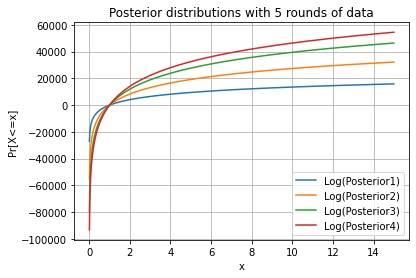

Germany
[(1024, 7.0068359375), (2386, 14.0068359375), (4015, 21.0068359375), (5330, 28.0068359375)]


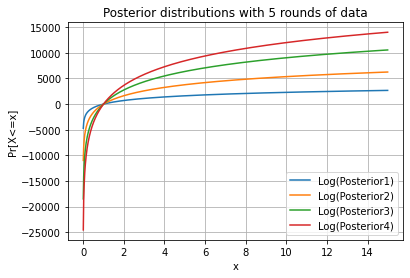

Italy
[(4934, 7.001418727199027), (8874, 14.001418727199027), (12523, 21.001418727199027), (15386, 28.001418727199027)]


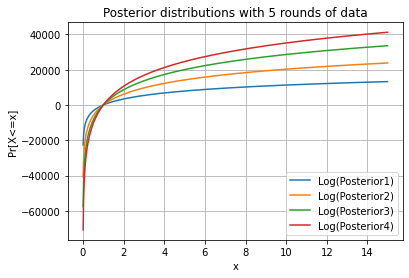

Spain
[(5715, 7.0012248468941385), (10149, 14.001224846894138), (13942, 21.00122484689414), (16482, 28.00122484689414)]


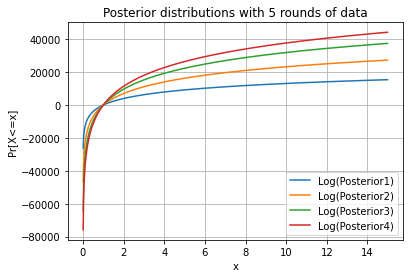

Turkey
[(481, 7.014553014553014), (1128, 14.014553014553014), (1972, 21.014553014553016), (2732, 28.014553014553016)]


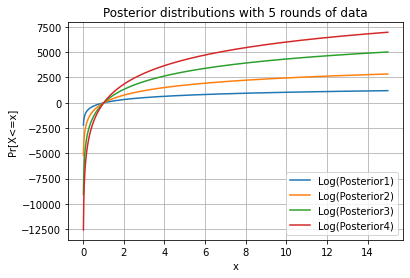

United_Kingdom
[(4390, 7.001594533029612), (10986, 14.001594533029612), (17008, 21.001594533029614), (22350, 28.001594533029614)]


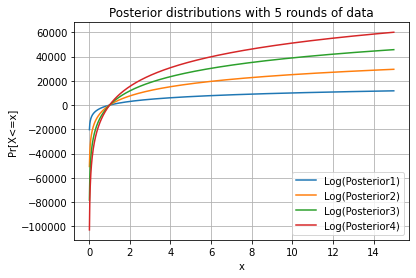

In [ ]:
## required inference 5
## Bayesian Inference
## datas is for first 4 weeks of april (April 1 - April 28)

def bayesian(data, beta):
    parameters = []
    minim = 0.01
    maxim = 15
    for i in range(1, 5):
        a = np.sum(data[:i * 7])
        b = beta + 7 * i
        parameters.append((a, b))
    print(parameters)
    X = np.arange(minim, maxim, 0.01)
    for i in range(4):
        a = parameters[i][0]
        b = parameters[i][1]
        Y = []
        for lamb in X:
            Y.append(a * np.log(lamb) - (lamb * b))
        plt.figure('Posterior Distributions')
        plt.plot(X, Y, label='Log(Posterior' + str(i + 1) + ')')
        plt.xlabel('x')
        plt.ylabel('Pr[X<=x]')
        plt.legend(loc="best")
        plt.title('Posterior distributions with 5 rounds of data')
    plt.grid()
    plt.show()

for country, four_week_deaths in covid_df.groupby('country'):
  print(country)
  first_week_deaths = four_week_deaths.loc[(four_week_deaths['day'] >= 1) & (four_week_deaths['day'] <= 7)]['death_cases']
  beta = 1/np.mean(first_week_deaths)
  bayesian(four_week_deaths['death_cases'], beta)

In [ ]:
## Sample inference 1
## germany vs italy residential Data Mean comparison using walds 2 sample One tailed Test

italy_df = filtered_x_df[filtered_x_df['country_region'].isin(['Italy'])]
germany_df = filtered_x_df[filtered_x_df['country_region'].isin(['Germany'])]

italy_resident = italy_df['residential_percent_change_from_baseline']
germany_resident = germany_df['residential_percent_change_from_baseline']

italy_sample_mean = np.mean(italy_resident)
germany_sample_mean = np.mean(germany_resident)
N = len(italy_resident)
walds2_statistic = (italy_sample_mean - germany_sample_mean)/np.sqrt(italy_sample_mean/N + germany_sample_mean/N)

neg_z_alpha = st.norm.ppf(.05)

print('Null Hypothesis H0: Italy Mean > Germany Mean Vs H1: Italy Mean <= Germany Mean')
print('Left Tailed walds 2 Sample Test assuming the underlying distribution is poisson')
print('Walds statistic', walds2_statistic)
print('critical value', neg_z_alpha)

if abs(walds2_statistic) < neg_z_alpha:
  print('Reject Null Hypothesis')
else:
  print('Accept Null Hypothesis')


Null Hypothesis H0: Italy Mean > Germany Mean Vs H1: Italy Mean <= Germany Mean
Left Tailed walds 2 Sample Test assuming the underlying distribution is poisson
Walds statistic 13.636297760051683
critical value -1.6448536269514729
Accept Null Hypothesis


In [ ]:
## Sample Inference 2
# Finding correlation between residential vs other mobility Factors in post covid era

# selected countries
countries = ['Italy', 'Spain', 'France', 'Germany', 'United Kingdom', 'Turkey']
df1 = filtered_x_df
correlation_factor = 'residential_percent_change_from_baseline'
external_factors = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                    'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']

# finding correlation for all countries
for country in countries:
    print('-----------------------------------------')
    print('__________country_________', country)
    print('')
    # finding the value of the major correlation factor from dataset
    x = df1.loc[(df1['country_region'] == country) & (df1['date'].between('04-01-2020', '04-30-2020'))]
    X = x[correlation_factor].values
    sample_mean_x = np.mean(X)
    for x_factor in external_factors:
        # finding the value of the other correlation factor from dataset
        Y = x[x_factor].values
        sample_mean_y = np.mean(Y)
        # applying pearson correlation coefficient formula
        num = np.sum(np.dot([i - sample_mean_x for i in X], [i - sample_mean_y for i in Y]))
        deno = np.sqrt(sum(np.square([i - sample_mean_x for i in X])) * sum(np.square([i - sample_mean_y for i in Y])))
        print('correlation between ' + correlation_factor + ' and' + ' ' + x_factor + ' ' + 'is ', num/deno)


-----------------------------------------
__________country_________ Italy

correlation between residential_percent_change_from_baseline and retail_and_recreation_percent_change_from_baseline is  0.010827565749131594
correlation between residential_percent_change_from_baseline and grocery_and_pharmacy_percent_change_from_baseline is  0.2248568997453969
correlation between residential_percent_change_from_baseline and parks_percent_change_from_baseline is  0.19886750759661462
correlation between residential_percent_change_from_baseline and transit_stations_percent_change_from_baseline is  -0.10857958656648783
correlation between residential_percent_change_from_baseline and workplaces_percent_change_from_baseline is  -0.7996886600460338
-----------------------------------------
__________country_________ Spain

correlation between residential_percent_change_from_baseline and retail_and_recreation_percent_change_from_baseline is  -0.012571617544342113
correlation between residential_percen

In [ ]:
# Sample Inference 3 
# Finding impact of covid on mobility factors using linear regression

# outlier datasets
combined_outliers = (('France', ['04-04-2020']), ('United Kingdom', ['04-12-2020']), ('Germany', ['04-10-2020', '04-13-2020']))
combined_outliers_dict = dict((x, y) for x, y in combined_outliers)

# method to find betas
def regression(X, y):
    betas = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    return betas

# selected countries
countries = ['Italy', 'Spain', 'France', 'Germany', 'United Kingdom', 'Turkey']
df1 = filtered_covid_df
df1['country'] = df1['country'].replace('United_Kingdom', 'United Kingdom', inplace=False)
df2 = filtered_x_df
df2_ = df2.rename(columns=({'country_region': 'country'}))
external_factors = ['transit_stations_percent_change_from_baseline']

# finding impact of deaths and cases on mobility for all countries
for country in countries:
    print('------------------------------------')
    print('_______Country______', country)
    x = df1.loc[(df1['country'] == country) & (df1['date'].between('04-01-2020', '04-30-2020'))]
    x_fact = df2_.loc[(df2_['country'] == country) & (df2_['date'].between('04-01-2020', '04-30-2020'))]

    # filter date outlier
    outlier_country_list = list(combined_outliers_dict.keys())
    if country in outlier_country_list:
        filtered_dates = combined_outliers_dict[country]
        # filtering X date outlier
        x = x[~x['date'].isin(filtered_dates)]
        # filtering Y date outlier
        x_fact = x_fact[~x_fact['date'].isin(filtered_dates)]
    X1 = x['death_cases'].values
    X2 = x['confirmed_cases'].values
    # finding impact on each mobility
    for x_factor in external_factors:
        x_factor_values = x_fact[x_factor].values
        X = np.array([X1, X2])
        y = np.array(x_factor_values)
        row_to_be_added = np.full((1, len(y)), 1)
        # adding row with 1 to calculate Beta 0
        X = np.vstack((row_to_be_added, X))
        betas = regression(X.transpose(), y)
        print('betas', betas)
        # calculating predicted y
        y_pred = betas[0] + betas[1] * X1 + betas[2] * X2
        print(x_factor, ' is ', y)
        print(x_factor, ' prediction is', y_pred)
        y_true, y_pred = np.array(y), np.array(y_pred)
        # MSE Error for MLR
        mean_squared_error = np.mean(np.square(y_true - y_pred))
        print('mean_squared_error', mean_squared_error)


------------------------------------
_______Country______ Italy
betas [-6.95574872e+01  1.08271806e-02 -4.27576824e-03]
transit_stations_percent_change_from_baseline  is  [-79. -79. -79. -80. -86. -78. -78. -78. -78. -77. -78. -88. -91. -77.
 -76. -76. -76. -77. -84. -79. -77. -76. -75. -73. -83. -81. -72. -74.
 -72. -71.]
transit_stations_percent_change_from_baseline  prediction is [-77.80317135 -82.13285063 -81.28811609 -80.8899186  -82.72924361
 -82.30577875 -78.05989024 -76.01192981 -80.11265665 -80.90658236
 -80.27955458 -82.92591853 -82.38741601 -76.93245461 -75.72545333
 -74.70285072 -80.06127595 -78.26711682 -79.28714745 -77.89758384
 -74.28808037 -75.4443443  -79.23534826 -75.84735818 -77.92716721
 -75.14219301 -76.67930565 -73.38759705 -74.36213562 -74.97956043]
mean_squared_error 11.86814920294638
------------------------------------
_______Country______ Spain
betas [-7.67831608e+01 -8.30307007e-03 -1.92353885e-04]
transit_stations_percent_change_from_baseline  is  [-84. -84